In [30]:
import pandas as pd
import numpy as np
import os

In [45]:
df = pd.read_stata('data/LSMS/malawi_2016/IHS4 Consumption Aggregate.dta')
df['cons'] = df['rexpagg']
df['cons'] = df['cons']/116.28 # accounting for purchasing power parity
df['phone_cons'] = df['rexp_cat083']
df['phone_cons'] = df['phone_cons']/100 # specific good so do not need to adjust for PPP

df.rename(columns={'hh_wgt': 'weight'}, inplace=True)
df = df[['case_id', 'cons', 'phone_cons']] # grab these columns

df_geo = pd.read_stata('data/LSMS/malawi_2016/HouseholdGeovariables_stata11/HouseholdGeovariablesIHS4.dta')
df_cords = df_geo[['case_id', 'HHID', 'lat_modified', 'lon_modified']]
df_cords.rename(columns={'lat_modified': 'lat', 'lon_modified': 'lon'}, inplace=True)

df_hhf = pd.read_stata('data/LSMS/malawi_2016/HH_MOD_F.dta')
df_hhf = df_hhf[['case_id', 'HHID', 'hh_f34', 'hh_f35']]
df_hhf['hh_f35'] /= 100


/Applications/anaconda3/envs/predicting-poverty-replication/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [46]:
df = pd.merge(df, df_cords[['case_id', 'HHID']], on='case_id')

In [47]:
df_combined = pd.merge(df, df_cords, on=['case_id', 'HHID'])
df_combined = pd.merge(df_combined, df_hhf, on=['case_id', 'HHID'])

In [48]:
df_combined.shape

(12447, 8)

In [49]:
df_combined.head()

,case_id,cons,phone_cons,HHID,lat,lon,hh_f34,hh_f35
0,301025230225,2560.039551,0.000000,0001c970eecf473099368557e2080b3e,-14.683761,34.915074,0.0,NaN
1,210374850204,14897.992188,162.633820,000509f5cfcc4b078a09672b09425e95,-14.005029,33.794591,1.0,15.0
2,311057710075,4022.653809,258.500214,000bc107780044e59327dbf7ec960ac1,-16.826165,35.269503,2.0,20.0
3,312048040073,3325.028320,0.000000,000d1d26325d4f73a2ffbb8a99ab4752,-15.004730,35.163219,0.0,NaN
4,311097790117,7148.121094,119.640808,00104e33315844fdb2b8c6fdd35912a1,-17.016698,35.079629,1.0,10.0


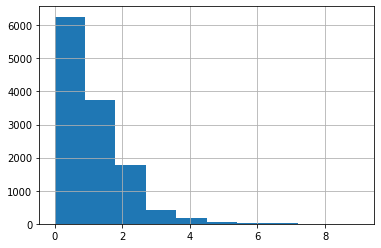

In [50]:
df_combined['hh_f34'].hist()

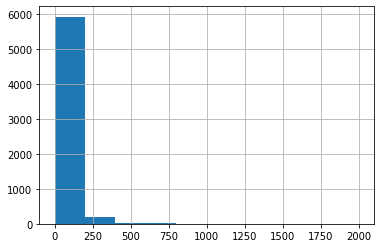

In [51]:
df_combined['hh_f35'].hist()

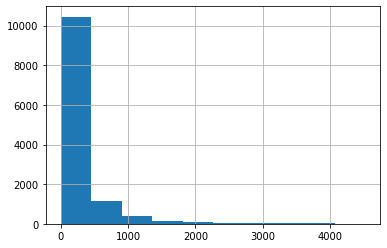

In [52]:
df_combined['phone_cons'].hist()

In [53]:
df_stats = df_combined.copy()

In [54]:
df_stats['cons_na'] = df_stats['cons'].isna()
df_stats['phone_na'] = df_stats['phone_cons'].isna()
df_stats['hh_f34_na'] = df_stats['hh_f34'].isna()
df_stats['hh_f35_na'] = df_stats['hh_f35'].isna()

In [55]:
df_stats

,case_id,cons,phone_cons,HHID,lat,lon,hh_f34,hh_f35,cons_na,phone_na,hh_f34_na,hh_f35_na
0,301025230225,2560.039551,0.000000,0001c970eecf473099368557e2080b3e,-14.683761,34.915074,0.0,NaN,False,False,False,True
1,210374850204,14897.992188,162.633820,000509f5cfcc4b078a09672b09425e95,-14.005029,33.794591,1.0,15.0,False,False,False,False
2,311057710075,4022.653809,258.500214,000bc107780044e59327dbf7ec960ac1,-16.826165,35.269503,2.0,20.0,False,False,False,False
3,312048040073,3325.028320,0.000000,000d1d26325d4f73a2ffbb8a99ab4752,-15.004730,35.163219,0.0,NaN,False,False,False,True
4,311097790117,7148.121094,119.640808,00104e33315844fdb2b8c6fdd35912a1,-17.016698,35.079629,1.0,10.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12442,205053630064,4161.387207,0.000000,ffe8b3cb44e646c4ba7e444c810b5262,-14.038697,34.511056,0.0,NaN,False,False,False,True
12443,307106820173,4508.041016,56.935036,ffe9da89ba74465ba9be8a7e8cbd77ce,-15.959665,35.034930,1.0,5.0,False,False,False,False
12444,208074540130,3620.645264,0.000000,ffe9e824c41f45c4aa5efb80d3ee9603,-14.263875,34.518640,0.0,NaN,False,False,False,True
12445,312048040036,2899.364258,0.000000,fffaa977174c43d79793cf945b57f948,-15.004730,35.163219,0.0,NaN,False,False,False,True


In [56]:
clust_nas = df_stats.groupby(['lat', 'lon']).mean().reset_index()[['lat', 'lon', 'phone_na', 'hh_f34_na', 'hh_f35_na']]


In [57]:
clust_counts = df_stats.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon', 'cons']].rename(columns={'cons': 'count'})


In [58]:
df_clusters = df_combined.groupby(['lat', 'lon']).mean().reset_index()

In [59]:
df_clusters.head()

,lat,lon,cons,phone_cons,hh_f34,hh_f35
0,-17.095150,35.217213,4746.557129,273.444763,0.8750,42.312500
1,-17.092351,35.114643,3741.755859,16.226484,0.1250,11.400000
2,-17.016698,35.079629,5159.424316,11.216326,0.1250,7.500000
3,-16.977243,35.205706,4650.909180,41.399769,0.1875,18.333333
4,-16.956385,35.168967,2806.638916,22.526325,0.2500,7.500000


In [60]:
df_clusters.shape

(780, 6)

In [61]:
df_clusters = pd.merge(df_clusters, clust_nas, on=['lat', 'lon'])
df_clusters = pd.merge(df_clusters, clust_counts, on=['lat', 'lon'])

In [62]:
df_clusters.head()

,lat,lon,cons,phone_cons,hh_f34,hh_f35,phone_na,hh_f34_na,hh_f35_na,count
0,-17.095150,35.217213,4746.557129,273.444763,0.8750,42.312500,0.0,0.0,0.5000,16
1,-17.092351,35.114643,3741.755859,16.226484,0.1250,11.400000,0.0,0.0,0.8750,16
2,-17.016698,35.079629,5159.424316,11.216326,0.1250,7.500000,0.0,0.0,0.8750,16
3,-16.977243,35.205706,4650.909180,41.399769,0.1875,18.333333,0.0,0.0,0.8125,16
4,-16.956385,35.168967,2806.638916,22.526325,0.2500,7.500000,0.0,0.0,0.7500,16


In [63]:
df_clusters['phone_cons']

0      273.444763
1       16.226484
2       11.216326
3       41.399769
4       22.526325
          ...    
775      6.542647
776    105.980751
777    185.438538
778    125.800255
779     89.273575
Name: phone_cons, Length: 780, dtype: float32

In [64]:
df_clusters.shape

(780, 10)

In [65]:
rename = {c: 'cluster_' + c if c not in ['lat', 'lon'] else c for c in df_clusters.columns}
df_clusters.rename(columns=rename, inplace=True)

In [66]:
import geoio
filename = 'data/Nightlights/2013/F182013.v4c_web.stable_lights.avg_vis.tif'
img = geoio.GeoImage(filename)

In [67]:
im_array = np.squeeze(img.get_data())

In [68]:
import math

def create_space(lat, lon):
    # these are pulled from the paper to make the 10km^2 area
    return lat - (180/math.pi)*(5000/6378137), lon - (180/math.pi)*(5000/6378137)/math.cos(lat), \
            lat + (180/math.pi)*(5000/6378137), lon + (180/math.pi)*(5000/6378137)/math.cos(lat)

In [69]:
household_nightlights = []
for i,r in df_clusters.iterrows():
    min_lat, min_lon, max_lat, max_lon = create_space(r.lat, r.lon)
    xminPixel, yminPixel = img.proj_to_raster(min_lon, min_lat)
    xmaxPixel, ymaxPixel = img.proj_to_raster(max_lon, max_lat)
    
    xminPixel, xmaxPixel = min(xminPixel, xmaxPixel), max(xminPixel, xmaxPixel)
    yminPixel, ymaxPixel = min(yminPixel, ymaxPixel), max(yminPixel, ymaxPixel)
    
    xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
    household_nightlights.append(im_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())

In [70]:
df_clusters['nightlights'] = household_nightlights

In [71]:
df_clusters.head()

,lat,lon,cluster_cons,cluster_phone_cons,cluster_hh_f34,cluster_hh_f35,cluster_phone_na,cluster_hh_f34_na,cluster_hh_f35_na,cluster_count,nightlights
0,-17.095150,35.217213,4746.557129,273.444763,0.8750,42.312500,0.0,0.0,0.5000,16,0.000000
1,-17.092351,35.114643,3741.755859,16.226484,0.1250,11.400000,0.0,0.0,0.8750,16,0.000000
2,-17.016698,35.079629,5159.424316,11.216326,0.1250,7.500000,0.0,0.0,0.8750,16,0.000000
3,-16.977243,35.205706,4650.909180,41.399769,0.1875,18.333333,0.0,0.0,0.8125,16,0.121212
4,-16.956385,35.168967,2806.638916,22.526325,0.2500,7.500000,0.0,0.0,0.7500,16,0.502674


In [72]:
df_clusters[['cluster_cons', 'cluster_phone_cons', 'cluster_hh_f34', 'cluster_hh_f35', 'nightlights']].corr()

,cluster_cons,cluster_phone_cons,cluster_hh_f34,cluster_hh_f35,nightlights
cluster_cons,1.000000,0.553713,0.497991,0.447005,0.387807
cluster_phone_cons,0.553713,1.000000,0.873184,0.858742,0.537487
cluster_hh_f34,0.497991,0.873184,1.000000,0.640965,0.535621
cluster_hh_f35,0.447005,0.858742,0.640965,1.000000,0.417294
nightlights,0.387807,0.537487,0.535621,0.417294,1.000000


In [73]:
df_clusters.to_csv('cluster_data.csv', index=False)